# 1 支持向量
使用高斯核函数的支持向量机（SVM）来构建垃圾邮件分类器。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
raw_data = loadmat('data/ex6data1.mat')
data = pd.DataFrame(raw_data.get('X'), columns=['X1', 'X2'])
data['y'] = raw_data.get('y')

data.head()

,X1,X2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


In [3]:
def plot_init_data(data, fig, ax):
    positive = data[data['y'].isin([1])]
    negative = data[data['y'].isin([0])] #清洗数据，删选过滤掉DataFrame中一些行

    ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')
    ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative')

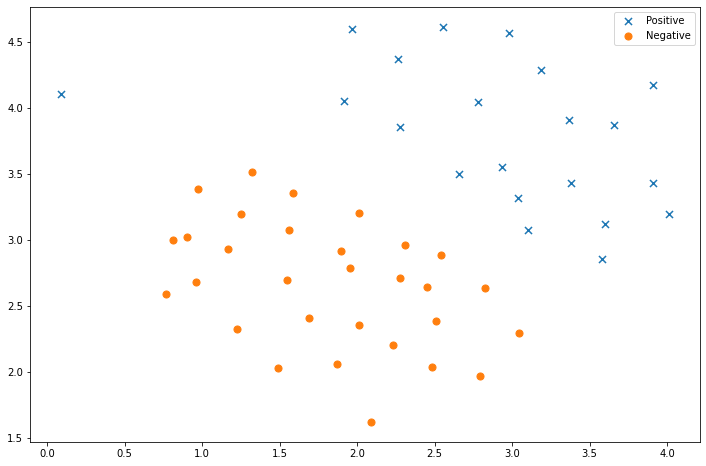

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
plot_init_data(data, fig, ax)
ax.legend()
plt.show()

In [5]:
from sklearn import svm
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=10000)
"""
C : float, optional (default=1.0)错误项的惩罚参数
loss : string, ‘hinge’ or ‘squared_hinge’ (default=’squared_hinge’) 指定损失函数。 
“hinge”是标准的SVM损失（例如由SVC类使用），而“squared_hinge”是hinge损失的平方。
max_iter : int, (default=1000) 要运行的最大迭代次数。
"""
svc

LinearSVC(C=1, loss='hinge', max_iter=10000)

In [6]:
svc.fit(data[['X1', 'X2']], data['y']) #输入参数训练模型
svc.score(data[['X1', 'X2']], data['y']) #得到分数

0.9803921568627451

In [7]:
def find_decision_boundary(svc, x1min, x1max, x2min, x2max, diff):
    x1 = np.linspace(x1min, x1max, 1000)
    x2 = np.linspace(x2min, x2max, 1000) #创建等差数列

    cordinates = [(x, y) for x in x1 for y in x2]
    x_cord, y_cord = zip(*cordinates) #zip（*）解压
    c_val = pd.DataFrame({'x1':x_cord, 'x2':y_cord})
    c_val['cval'] = svc.decision_function(c_val[['x1', 'x2']])

    decision = c_val[np.abs(c_val['cval']) < diff]
    
    return decision.x1, decision.x2

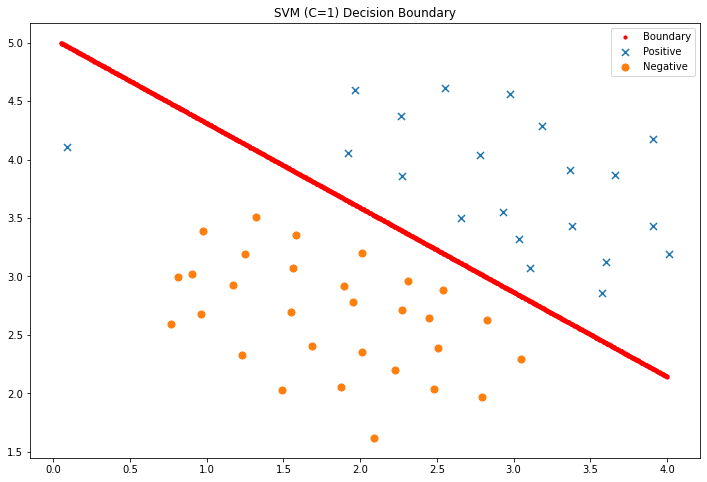

In [8]:
x1, x2 = find_decision_boundary(svc, 0, 4, 1.5, 5, 2 * 10**-3)
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, s=10, c='r',label='Boundary')
plot_init_data(data, fig, ax)
ax.set_title('SVM (C=1) Decision Boundary')
ax.legend()
plt.show()

In [9]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=20000)
svc2.fit(data[['X1', 'X2']], data['y'])
svc2.score(data[['X1', 'X2']], data['y'])

0.9803921568627451

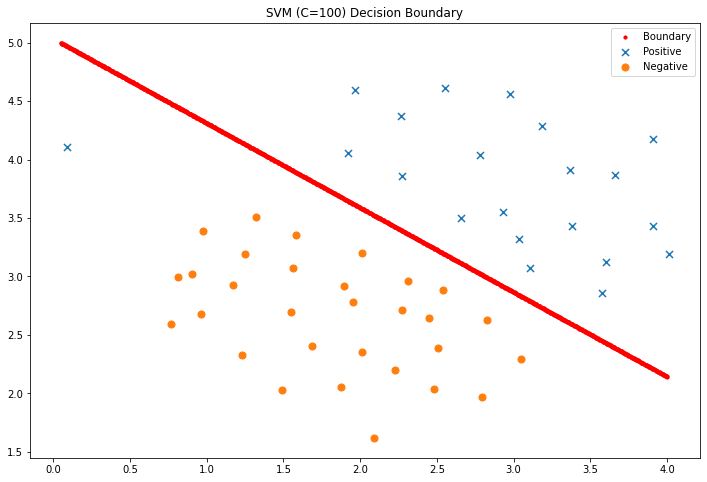

In [10]:
x1, x2 = find_decision_boundary(svc, 0, 4, 1.5, 5, 2 * 10**-3)
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, s=10, c='r',label='Boundary')
plot_init_data(data, fig, ax)
ax.set_title('SVM (C=100) Decision Boundary')
ax.legend()
plt.show()

#### 1.2 高斯内核的SVM
将从线性SVM转移到能够使用内核进行非线性分类的SVM。
虽然scikit-learn具有内置的高斯内核，但为实现更清楚，将从头开始实现。

In [11]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))

In [12]:
x1 = np.array([1.0, 2.0, 1.0])
x2 = np.array([0.0, 4.0, -1.0])
sigma = 2

gaussian_kernel(x1, x2, sigma)

0.32465246735834974

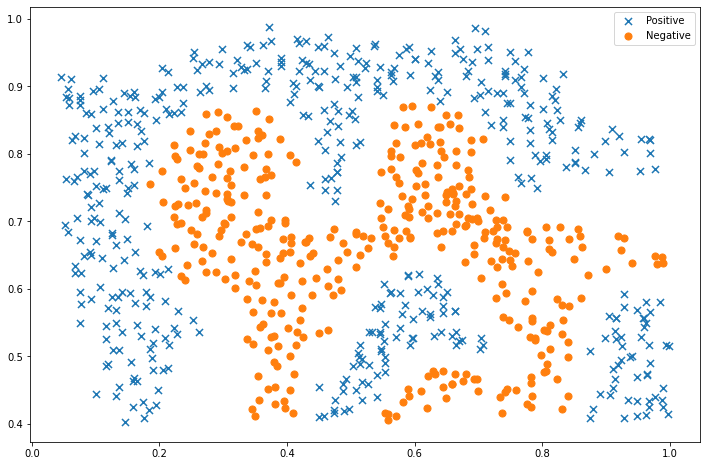

In [13]:
raw_data = loadmat('data/ex6data2.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

fig, ax = plt.subplots(figsize=(12,8))
plot_init_data(data, fig, ax)
ax.legend()
plt.show()

In [14]:
svc = svm.SVC(C=100, gamma=10, probability=True)
"""
gamma ： ‘rbf’,‘poly’ 和‘sigmoid’的核函数参数。默认是’auto’，则会选择1/n_features
kernel ：核函数，默认是rbf，可以是‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
RBF函数：exp(-gamma|u-v|^2)

"""
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9698725376593279

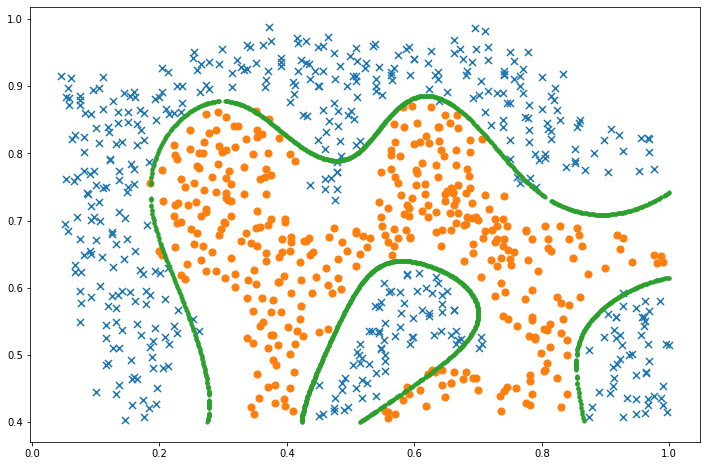

In [15]:
x1, x2 = find_decision_boundary(svc, 0, 1, 0.4, 1, 0.01)
fig, ax = plt.subplots(figsize=(12,8))
plot_init_data(data, fig, ax)
ax.scatter(x1, x2, s=10)
plt.show()

#### 1.2.3 数据集3
对于第三个数据集，我们给出了训练和验证集，并且基于验证集性能为SVM模型找到最优超参数。超参数是在开始学习过程之前设置值的参数
我们现在需要寻找最优和，候选数值为[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

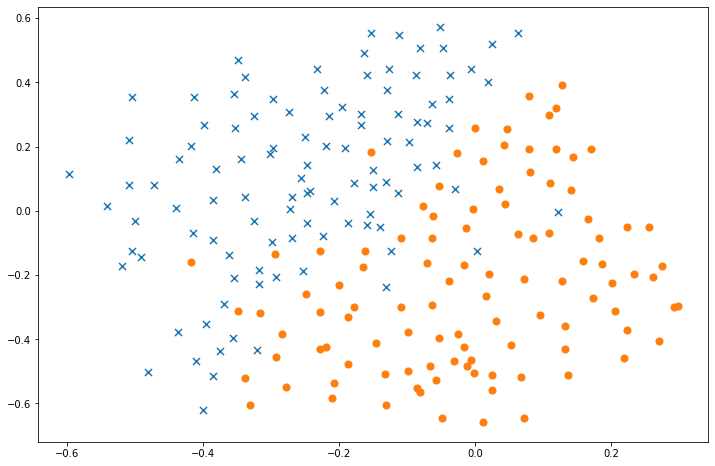

In [16]:
raw_data = loadmat('data/ex6data3.mat')

X = raw_data['X']
Xval = raw_data['Xval']
y = raw_data['y'].ravel()
yval = raw_data['yval'].ravel()

fig, ax = plt.subplots(figsize=(12,8))
data = pd.DataFrame(raw_data.get('X'), columns=['X1', 'X2'])
data['y'] = raw_data.get('y')
plot_init_data(data, fig, ax)
plt.show()

In [17]:
C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0
best_params = {'C': None, 'gamma': None}

for C in C_values:
    for gamma in gamma_values:
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X, y)
        score = svc.score(Xval, yval)
        
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

best_score, best_params

(0.965, {'C': 0.3, 'gamma': 100})

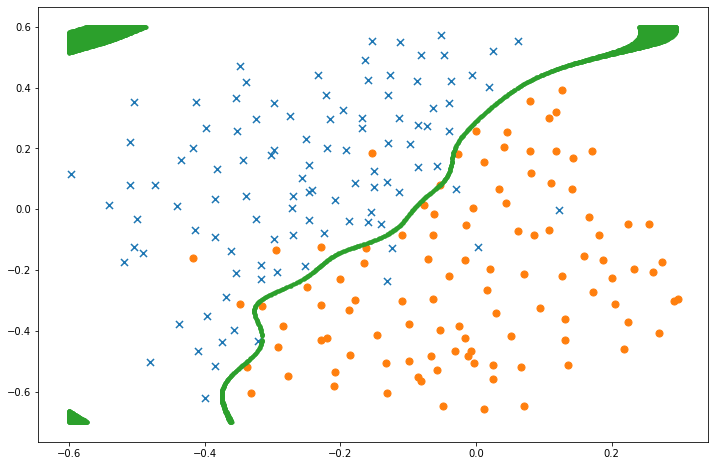

In [18]:
svc = svm.SVC(C=best_params['C'], gamma=best_params['gamma'])
svc.fit(X, y)

x1, x2 = find_decision_boundary(svc, -0.6, 0.3, -0.7, 0.6, 0.005)
fig, ax = plt.subplots(figsize=(12,8))
plot_init_data(data, fig, ax)
ax.scatter(x1, x2, s=10)
plt.show()

# 2 垃圾邮件分类
使用SVM来构建垃圾邮件过滤器。
预处理步骤（如HTML删除，词干，标准化等）已经完成，只需将字词映射到为练习提供的字典中的ID

In [19]:
spam_train = loadmat('data/machine-learning-ex6/ex6/spamTrain.mat')
spam_test = loadmat('data/machine-learning-ex6/ex6/spamTest.mat')

spam_train 

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'y': array([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]], dtype=uint8)}

In [20]:
#每个文档转换为一个向量，其中1,899个维对应于词汇表中的1,899个单词。 它们的值为二进制，表示文档中是否存在单词
X = spam_train['X']
Xtest = spam_test['Xtest']
y = spam_train['y'].ravel()
ytest = spam_test['ytest'].ravel()

X.shape, y.shape, Xtest.shape, ytest.shape

((4000, 1899), (4000,), (1000, 1899), (1000,))

In [21]:
svc = svm.SVC()
svc.fit(X, y)

SVC()

In [22]:
print('Training accuracy = {0}%'.format(np.round(svc.score(X, y) * 100, 2))) #np.round：取整
print('Test accuracy = {0}%'.format(np.round(svc.score(Xtest, ytest) * 100, 2)))
#.format()，字符串格式化，例：'数字{1}{2}和{0}'.format("123",456,'789')>>>'数字456789和123'

Training accuracy = 99.32%
Test accuracy = 98.7%


In [23]:
kw = np.eye(1899) #生成对角阵
kw[:3,:]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
spam_val = pd.DataFrame({'idx':range(1899)})
spam_val['isspam'] = svc.decision_function(kw) 
spam_val['isspam'].describe() #打印数据的统计信息

count    1899.000000
mean       -0.110039
std         0.049094
min        -0.428396
25%        -0.131213
50%        -0.111985
75%        -0.091973
max         0.396286
Name: isspam, dtype: float64

In [25]:
decision = spam_val[spam_val['isspam'] > -0.55]
decision

,idx,isspam
0,0,-0.093653
1,1,-0.083078
2,2,-0.109401
3,3,-0.119685
4,4,-0.165824
...,...,...
1894,1894,0.101613
1895,1895,-0.016065
1896,1896,-0.151573
1897,1897,-0.109022


In [26]:
path =  'data/machine-learning-ex6/ex6/vocab.txt'
voc = pd.read_csv(path, header=None, names=['idx', 'voc'], sep = '\t')
voc.head()

,idx,voc
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about


In [27]:
spamvoc = voc.loc[list(decision['idx'])]
spamvoc

,idx,voc
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about
...,...,...
1894,1895,your
1895,1896,yourself
1896,1897,zdnet
1897,1898,zero
